# CSCI 3352 Biological Networks, Spring 2021, Prof. Clauset
Submit here: https://canvas.colorado.edu/courses/69236

# Problem Set 4 : Predicting missing node attributes in networks

***

**Name**: Clayton Schneider

***

This assignment is due on Canvas by **11:55pm on Friday, February 12th**. Your solutions to non-programming questions should be done in Markdown directly below the associated question. Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own** (see syllabus for detailed guidance). There are 90 points total, and 25 pts extra credit.

**NOTES**: 

- Unless a url is given for a data set, you will find the required data on the course Canvas.
- If you're not familiar with typesetting math directly in Markdown, you may do your work on paper first and then typeset it later. This [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) provides helpful guidance for writing math in Markdown. 
- It is **unhelpful** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code.

***
* [Documentation for networkx](https://networkx.github.io/documentation/stable/)

[//]: <> (Documentation for igraph Python https://igraph.org/python/ )

In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline

***
## Problem 1 : Label me this, label me that (85 pts total)

In this problem, you will implement and systematically evaluate the `local smoothing` prediction algorithm. We'll build up this numerical experiment in stages. First, you'll implement the `baseline` predictor, then the `local smoothing` predictor. After that, you'll construct a *good* test of the `local smoothing` algorithm for a single choice of a _missingness function_ $f$. And finally, you'll write a wrapper around this function to explore how performance varies as a function of $f$.

For the last two steps, we'll use a real-world network derived from the genes of the human malaria parasite _P. falciparum_. These genes are located in one of nine highly variable regions (HVRs) in the DBLa domain of the parasite's var protein. In this network, nodes are antigen *genes* of the parasite and two nodes are connected if they contain evidence of past non-homologous *recombination* (basically, if they share a long subsequence). The node metadata represents a biologically-relevant classification scheme of the nodes.
* Visit the [Index of Complex Networks](https://icon.colorado.edu/) and obtain the `HVR_5` network and `metadata_CysPoLV` node attribute files for the ICON entry _Malaria var DBLa HVR networks_.

### Problem 1-A (10 pts) Malaria gene recombination network

To warm up, load both the *HVR_5* network and treat it as a simple graph (edges unweighted and undirected; no multi-edges; no self-loops), and the *metadata_CysPoLV* file. Then calculate and report the following.
* number of nodes $n$
* (undirected) edges $m$
* mean degree $\langle k \rangle$
* clustering coefficient $C$
* mean geodesic distance $\langle \ell \rangle$
* a `ridiculogram` of the network, using the provided `drawGz()` function
* a `bar` plot showing the attribute frequencies in the `metadata` file

Note: In the code box below, the preamble takes care of the tricky part of correctly aligning the network data with the node metadata, so that you can focus on the analysis parts.

In [2]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : a ridiculogram plot of G
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11c6d6','#d67711','#11d646','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)

    node_colors = []
    for i in G.nodes():
        node_colors.append(colors[int(z[i])-1])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 50
        flabel = False
        
    nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [10]:
# this data set is from :
# D. B. Larremore et al., "A network approach to analyzing highly recombinant malaria parasite genes."
#                          PLOS Computational Biology 9(10), e1003268 (2013).
fname1 = 'HVR_5.txt'
fname2 = 'metadata_CysPoLV.txt'

# read in the network file (an edge list)
print(f'reading the network file  : {fname1}')
G = nx.read_edgelist('./' + fname1, delimiter=',', nodetype=int)  # import simple graph, index nodes by integers (not strings)

# read in the node metadata (note: there are more metadata values here than nodes in G)
print(f'reading the metadata file : {fname2}\n')
f = open('./' + fname2,'r')
labels = []
for line in f:
    labels.append(int(line.rstrip('\n'))) # strip the \n and convert label to an int
f.close() 

# for each node i in G, add (j: j's label) to a dictionary z
z = {}
for i in range(0,len(labels)):
    if i+1 in G.nodes():
        z[i+1] = labels[i] 
    
####################################
##### do not modify above here #####

n = len(G.nodes())
m = len(G.edges())
kmean = np.mean(G.degree())
C = nx.transitivity(G)
ellmean = nx.average_shortest_path_length(G)

##### do not modify below here #####
####################################

print(f'number of nodes, n  = {n}')
print(f'number of edges, m  = {m}')
print(f'mean degree,    <k> = %5.2f' % kmean)
print(f'clustering coefficient, C     = %5.2f' % C)
print(f'mean geodesic distance, <ell> = %5.2f' % ellmean)

reading the network file  : HVR_5.txt
reading the metadata file : metadata_CysPoLV.txt

number of nodes, n  = 298
number of edges, m  = 2684
mean degree,    <k> = 87.31
clustering coefficient, C     =  0.36
mean geodesic distance, <ell> =  2.92


### Problem 1-B (10 pts) : the baseline

* Write the function `predictLabel_baseline(x)` to implement the `baseline` node attribute predictor given in Lecture Notes 4.
  * It takes as input `x`, a dictionary of observed labels (node i: label of i), within which a $-1$ indicates a missing label.
  * It returns as output, the result of the baseline predictor.
* Then, write code in the cell below that to
  * apply your predictor to each of the nodes in the $G_\circ$ given below,
  * for each prediction, print a statement of the form `node 1 : -1 -> 2 (baseline)` that gives the node a prediction was made for, its observed `x` value and its predicted value, and then
  * store the final labels (non-missing observed + predictions) in a dictionary `xp`.

Note: the preamble below includes the graph `Go`, and a given labeling `x`, and will display both.

In [18]:
def predictLabel_baseline(x):
    # input:  x, dict of observed labels
    # output: baseline predictor, Uniform(\vec{x}-\emptyset)
    
    return int(np.mean([x[key] for key in x if x[key] != -1]))


initial node labels and network:
node 1, label -1
node 2, label 1
node 3, label 2
node 4, label 2
node 5, label -1
node 6, label 3


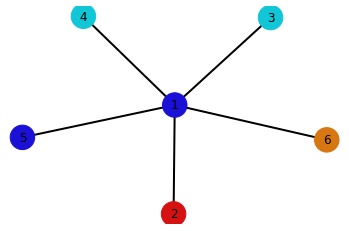


applying baseline predictor to
node 1 : -1 -> 2
node 5 : -1 -> 2

final node labels and network:
node 1, label 2
node 2, label 1
node 3, label 2
node 4, label 2
node 5, label 2
node 6, label 3


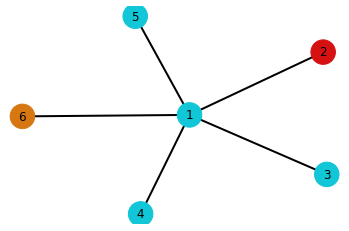

In [20]:
import random as rnd
seed = 698 # your MMYY birthday here
rnd.seed(seed)

# a small network to test your baseline predictor
Go = nx.Graph([(1,2),(1,3),(1,4),(1,5),(1,6)])

# and its observed node labels x, as a dictionary
x = {1: -1, 2: 1, 3: 2, 4: 2, 5: -1, 6: 3}

# to start, display the observed labels and draw G with them
print(f'initial node labels and network:')
for i in x:
    print(f'node {i}, label {x[i]}')
drawGz(Go,x)

xp = {} # put your node labels, after predictions, here (as a dictionary)
print(f'\napplying baseline predictor to')

####################################
##### do not modify above here #####

for node in Go.nodes():
    if x[node] == -1:
        xp[node] = predictLabel_baseline(x)
        print('node', node, ':', x[node], '->', xp[node])
    else:
        xp[node] = x[node]

##### do not modify above here #####
####################################
print(f'\nfinal node labels and network:')
for i in xp:
    print(f'node {i}, label {xp[i]}')
drawGz(Go,xp)

### Problem 1-C (15 pts) : local smoothing

* Now write a function `predictLabel_local(G,i,x,flag)` that implements the `local smoothing` node attribute predictor for categorical variables given in Lecture Notes 4.
  * It takes as input the graph `G`, a node index `i`, and a dictionary of observed labels `x`, as before.
  * As in Problem Set 2, `flag` is a binary variable that toggles whether for each prediction, it prints a statement of the form `node 1 : -1 -> 2 ([method])`, where `method` is either `smoothing` or `baseline`, depending on which predictor was applied.

* Then,
  * apply your predictor (with `flag=1`) to each of the nodes in the $G_\circ$ given below, and then
  * store the final labels (non-missing observed + predictions) in a dictionary `xp`.

Hint 1: Don't forget that the `local smoothing` predictor should default to the `baseline` predictor in the event that all of a node's neighbors are missing their labels.

Hint 2: To avoid having the output of an early prediction influence the output of a later prediction, for each node $i$, use the `xp` variable to store both the output of any prediction, or the observed label (if no prediction is made). That is, make your predictions *synchronously*.

In [ ]:
def predictLabel_local(G,i,x,flag):
    # input:  G, simple networkx graph
    #         i, a node in G whose label we will predict
    #         x, dict of observed labels for G
    #         flag, binary value
    # output: local smoothing predictor output for i
    #         a print statement (see instructions) if flag=1
    pred = 0
    neighbors = G.neighbors(i)
    if any()
    for neighbor in G.neighbors(i):
    if any()
        pred = np.mean([x[nei] for nei in G.neighbors(i) if x[nei] != -1])
    
    


In [ ]:
import random as rnd
seed = # your MMYY birthday here
rnd.seed(seed)

# a graph and its observed node labels, to start
Go = nx.Graph([(1,2),(1,3),(1,4),(1,5),(1,6)])
x  = {1: -1, 2: 1, 3: 2, 4: 3, 5: -1, 6: 2}

# to start, display the observed labels and draw G with them
print(f'initial node labels and network:')
for i in x:
    print(f'node {i}, label {x[i]}')
drawGz(Go,x)

xp = {} # put your node labels, after predictions, here (as a dictionary)
print(f'\napplying baseline predictor to')

####################################
##### do not modify above here #####



### YOUR CODE



##### do not modify above here #####
####################################
print(f'\nfinal node labels and network:')
for i in xp:
    print(f'node {i}, label {xp[i]}')
drawGz(Go,xp)

### Problem 1-D (35 pts) : missingness

Now we get to play with malaria gene data. Let the missingness function $f$ be one that selects a uniformly random _fraction_ $\alpha\in(0,1)$ of attributes to observe. And, define the performance measure to be the `accuracy (ACC)`.

Because $f$ is a stochastic function, the accuracy we calculate will be a random variable. Hence, just like in Problem Set 3, we will need to average the accuracy over several _repetitions_ to get a good estimate.

* Write a function `compute_ACC_onG(G,x,alpha)` that computes the ACC for applying the `local smoothing` predictor to an instance of $G$ in which we observe each node's attribute with probability $\alpha$. This function takes as input the network `G`, the actual node labels `x`, and the value $\alpha$. It should then construct an observed set of labels `xo`, produce a set of predicted labels `xp`, and then return the ACC for those predictions.
* In the cell below that, write a wrapper around your function that computes the ACCs over `nrep=10` repetitions, each with $\alpha=0.8$.
* Report both
  * the list of individual ACCs (one per rep) and
  * their average over all reps.
* Finally, in the discussion box below that, briefly comment about how well `local smoothing` does at this task, in light of any class balance issues.

Hint 1: I used a $c \times c$ numpy array, where $c$ is the number of unique labels in `x`, to construct the confusion matrix, and then used the `np.trace()` and `.sum()` functions to get the ACC.

Hint 2: You can check that your code is about right by trying a few different values of $\alpha$. When I ran it with $\alpha=0.05$, I found ACC $\approx0.50$, and with $\alpha=0.95$, I found ACC $\approx0.70$. This makes sense that ACC should increase with $\alpha$, since at higher values, we're making fewer predictions and have more observed labels to work with.

In [ ]:
def compute_ACC_onG(G,x,alpha):
    # input : G, a networkx simple graph
    #         x, (dict) actual labels of nodes in G
    #         alpha, (scalar) fraction of labels to hide
    # output: ACC of local smoothing predictor

    # YOUR CODE HERE
    

In [ ]:
import random as rnd
seed = # your MMYY birthday here
rnd.seed(seed)

nreps  = 10   # number of repetitions to average over
alpha  = 0.80  # fraction of labels to observe
ACCs   = []   # list of nrep values of ACC

##### do not modify above here #####
####################################



# YOUR CODE HERE


    
####################################
##### do not modify below here #####    
print(f'[ n={n} | reps={nreps} ] <ACC> = %6.3f' % np.mean(ACCs))

Your discussion here

### Problem 1-E (20 pts) putting it all together

Using the code you wrote for `Problem 1-D`, write a simple wrapper around it that performs the full numerical experiment to investigate how the `local smoothing` predictor performs (mean ACC over reps) as a function of how much of the network is labeled (alpha).

* Write the wrapper around your `Problem 1-D` code to measure how the mean ACC varies a function of $\alpha$ on the malaria gene network.

* Produce a single `plot` showing this function, for $\alpha=\{0.1, 0.3, 0.5, 0.7, 0.9\}$ and `nreps=100` (try a smaller number to see how much roughness you're smoothing over).
* (*Extra credit 5pts*: use at least 10 evenly-spaced increments of $\alpha$ between 0 and 1.)

* Briefly discuss what you see about how the ACC varies with $\alpha$. What trend do you see? Does it go in the direction you would expect? Why is the worst accuracy better than $1/c$, where $c$ is the number of unique labels? Try to give some intuition as to why this behavior makes sense given what we know about how `local smoothing` works and the mean degree $\langle k \rangle$ of the malaria gene network.

Hint: As in PS3, a key part of such a numerical experiment is how you store the intermediate results. For each choice of $\alpha$, the core code from `Problem 1-D` will produce a single pair that you can plot $(\alpha,\textrm{ACC})$, but you'll need to store these pairs of values while the rest are being calculated. It may be useful to separate the code for the experiment from the code for the visualization, so that you can tinker with the latter without having to re-run the former.

In [ ]:
# YOUR NUMERICAL EXPERIMENT CODE HERE

In [ ]:
# YOUR PLOTTING CODE HERE

Your discussion here

***
***

## Problem 2 : Reading the literature (*10 pts extra credit*)

Choose a paper from the [Supplemental Reading list on the external course webpage](http://tuvalu.santafe.edu/~aaronc/courses/3352/). Read the paper (the whole paper, not just the abstract). Think about what it says. Then, write 1-3 sentences for each of the following questions in a way that clearly summarizes the work, and its context.
* What was the research question?
* What was the approach the authors took to answer that question?
* What did they do well?
* What could they have done better?
* What extensions can you envision?


Do not copy any text from the paper itself; write your own summary, in your own words in Markdown in the corresponding box below. Be sure to answer each of the five questions. The amount of extra credit will depend on the accuracy and thoughtfulness of your answers.

Hint: This is a good way to generate some ideas for your class project. Also, even if you don't understand everything in the paper, that's okay. Do your best to summarize what you did understand.

* *What paper did you choose?*<br/>
Give the Authors, Title, Publication Venue, Year
<br/>

* *What was the research question?*<br/>
Your answer here
<br/>

* *What was the approach the authors took to answer that question?*<br/>
Your answer here
<br/>

* *What did they do well?*<br/>
Your answer here
<br/>

* *What could they have done better?*<br/>
Your answer here
<br/>

* *What extensions can you envision?*<br/>
Your answer here

***
***

## Problem 3 : Index of Complex Networks (*10 pts extra credit*)

The *Index of Complex Networks* (ICON) is the largest index of real-world complex network data sets available. It's not a repository, and instead lists network data sets that can be found elsewhere on the public web. Each record in ICON provides basic information about the network, including its domain, subdomain, size, graph properties, a brief description, bibliographic reference, and instructions or a link for obtaining the data set from its host.

For this question, find a biological network data set *that is not currently in ICON* and
* [**suggest** a data set at ICON](https://icon.colorado.edu/#!/suggestions), and 
* **record** below the information that you used to create that suggestion.

Follow the guidelines in the [ICON QuickStart Guide](http://santafe.edu/~aaronc/ICON_Suggestion_Guide.pdf) to create your entry. The amount of extra credit will depend on the entry's quality (loosely defined as how little editing I need to do to make it conform to the standards of the index), and no credit will be given for suggestions that duplicate an existing ICON entry (so be sure to check first) or have many missing fields.

Hints: Before going looking for network data, take some time to browse ICON in order to get a sense of both what kinds of data it contains already, and the style of its entries. Generally, the best place to find biological network data sets is in the scientific literature ([Google Scholar](https://scholar.google.com) is always a good place to start). Often the networks are mentioned in a published paper, and you can find the data on the authors' website or in the published paper's supplementary materials. Completing the suggestion may require downloading the data files to count the number of nodes and edges, and to record the file size properly. 

**Your ICON suggestion here**:

Title:     <br/>
Domain:     <br/>
Subdomain:     <br/>
Edge type:     <br/>
Node type:     <br/>
Graph properties:     <br/>
Description:     <br/>

Source URL (for the paper):     <br/>
Citation:     <br/>
Hosted by (who hosts the data):     <br/>

Network name:     <br/>
Nodes:     <br/>
Edges:     <br/>
Filesize (bytes):     <br/>
File type:     <br/>
File format:     <br/>
File URL: 